In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
%matplotlib inline96

In [2]:
# data initialization
file_names = ['0.jpg']
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)

In [4]:
# get coordinates
for filename in file_names:

    # read the Train and Train Dotted images
    image_1 = cv2.imread("./kaggle_sea_lions/TrainDotted/" + filename)
    image_2 = cv2.imread("./kaggle_sea_lions/Train/" + filename)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)

    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255

    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255

    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)

    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)

    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        g,b,r = image_1[int(y)][int(x)][:]

        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))

    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups

In [5]:
# extract 96 x 96 patches
x = []
y = []
for filename in file_names:    
    image = cv2.imread("./kaggle_sea_lions/Train/" + filename)
    for lion_class in classes:
        for coordinates in coordinates_df[lion_class][filename]:
            thumb = image[coordinates[1]-48:coordinates[1]+48,coordinates[0]-48:coordinates[0]+48, :]
            if np.shape(thumb) == (96, 96, 3):
                x.append(thumb)
                y.append(lion_class)
x = np.array(x)
y = np.array(y)

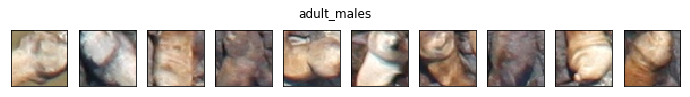

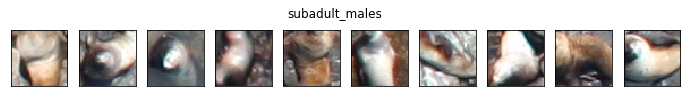

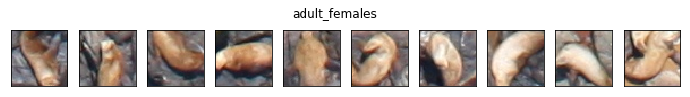

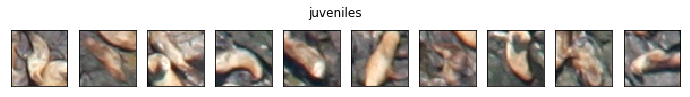

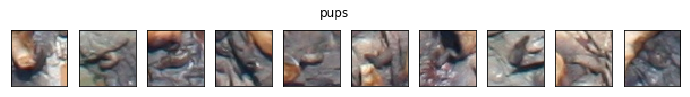

In [6]:
# plot examples
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break